In [1]:
# Run this cell only if you are using Google Colab. 

# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64
  !pip install ttictoc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 3.5 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 129496 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-2_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-2) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack ...

In [2]:
def PacejkaLinearizer(D,C,B,E,ab):
  Fy_bar= D*sym.sin(C*sym.arctan(B*ab-E*(B*ab-sym.arctan(B*ab))))
  c_bar = (C*D*np.cos(C*np.arctan(B*ab+E*(np.arctan(B*ab)-B*ab)))*(B-E*(B-B/(B**2*ab**2+1))))/((ab*B+E*(np.arctan(B*ab)-B*ab))**2+1)
  alpha_bar = ab

  return Fy_bar, c_bar, alpha_bar

In [3]:
def DugoffLinearizer(slip_angle,slip_ratio, ca, cs, mu, Fz):
  lamb_bar = mu*Fz*(1+slip_ratio)/(2*((cs*slip_ratio)**2+(ca*np.tan(slip_angle))**2)**0.5)
  
  if slip_angle !=0 or slip_ratio !=0:
    if lamb_bar < 1: 
      fbar = lamb_bar*(2-lamb_bar)
      c_bar = (Fz*ca*mu*(np.tan(slip_angle)**2 + 1))/(2*(ca**2*np.tan(slip_angle)**2 + cs**2*slip_ratio**2)**(1/2)) - (Fz*ca**3*mu*np.tan(slip_angle)**2*(np.tan(slip_angle)**2 + 1))/(2*(ca**2*np.tan(slip_angle)**2 + cs**2*slip_ratio**2)**(3/2))

      
    else:
      fbar = 1
      c_bar = (ca*(np.tan(slip_angle)**2 + 1))/(slip_ratio + 1)
    Fy_bar= ca*np.tan(slip_angle)*fbar/(1+slip_ratio)
    c_bar = c_bar.item()
    Fy_bar = Fy_bar.item()
                                                                 
  else:
    fbar = 1
    c_bar = ca.item()
    Fy_bar = 0

  return Fy_bar, c_bar, slip_angle

In [14]:
import numpy as np
from scipy.linalg import block_diag
import sympy as sym
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition

# States: y,v,psi, r, phi, phi_dot
# Inputs: Change in each wheel torque and in each wheel steer angle
def CFTOC_VD(slip_angle, slip_ratio, ca, cs, mux,muy, fz0,fy0, u,reff,xd,tf,tr,lf,lr,ms,hs,m,ixx,ks,ls,g,bs,iz,kus_d,Ts,Q,R,W0,Phir,alphamax,Qmax ,Qmin, deltamax,x0,yd,N):
  """
  STATES:
  y: lateral position
  vy: lateral speed
  psi: heading angle
  r: yaw rate
  phi: roll angle
  phid: roll rate
  
  =================================================================
  =================================================================
  Input Definitions:

  slip_angle: tire slip angle at each tire (aka alpha) --- (5x1)
  slip_ratio: tire slip ratio at each tire (aka sigma) --- (5x1)
  ca: tire cornering stifness (aka C_alpha)            --- (5x1)
  cs: tire longitudinal stiffness (aka C_sigma)        --- (5x1)
  mux: coefficient of friction in x                    --- (scalar)
  muy: coefficient of friction in y                    --- (scalar)
  fz0: tire vertical load                              --- (5x1)
  fyo: tire lateral load                               --- (5x1)
  u: longitudinal velcoity                             --- (scalar)
  reff: tire effective radius of rotation              --- (scalar)
  delta1: initial commanded steering input             --- (scalar)
  tf: front wheel track (dist between tire centers)    --- (scalar)
  tr: rear wheel track (dist between tire centers)     --- (scalar)
  lf: distance from cg to front wheels                 --- (scalar)
  lr: distance from cg to rear wheels                  --- (scalar)
  ms: vehicle sprung mass (without mass of tires and suspension) --- (scalar)
  hs: cg of sprung mass to roll center                 --- (scalar)
  m: total mass of vehicle (sprung and unsprung)       --- (scalar)
  ixx: moment of inertia about the x-axis (roll)       --- (scalar)
  ks: spring stiffness of suspension                   --- (scalar)
  ls: distance between suspension fixtures to vehicle  --- (scalar)
  g: gravity                                           --- (scalar)
  bs: suspension damping coefficient                   --- (scalar)
  iz: vehivle moment of inertia about z axis (yaw)     --- (scalar)
  kus_d: desired understeer coefficient of vehicle     --- (scalar)
  rmax: maximum allowed yaw rate (to be selected)      --- (scalar)
  Ts: sampling time for euler discretization           --- (scalar)
  Q: cost matrix for states                            --- (5x5)
  R: cost matrix for inputs                            --- (5x5)
  W0: initial torques and steering angles [Q1,delta1,Q2,delta2,Q3,delta3,Q4,delta4] ---(8x1)
  Phir: banking angle at over the prediction horizon   --- (Nx1)
  alphamax: maximum allowable rear wheel side slip     --- (scalar)
  Qmax: maximum torque attainable at each wheel        --- (scalar)
  deltamax: maximum steering angle                     --- (scalar)
  x0: initial states [y,vy,r,phi,phid]                 --- (5x1)
  psid: desired heading angle                          --- (scalar)
  yd:desired lateral position                          --- (scalar)
  N: MPC Prediction horizon                            --- (scalar)
  """
  psi_desired = np.arctan(yd/xd)
  if u != 0:
    delta1 = psi_desired - x0[1]/u
  else: 
    delta1 = psi_desired
  print(delta1)
  # Tire model Linearization 
  fy1, ca1, a1 = DugoffLinearizer(slip_angle[0],slip_ratio[0], ca[0], cs[0], mux, fz0[0])
  fy2, ca2, a2 = DugoffLinearizer(slip_angle[1],slip_ratio[1], ca[1], cs[1], mux, fz0[1])
  fy3, ca3, a3 = DugoffLinearizer(slip_angle[2],slip_ratio[2], ca[2], cs[2], mux, fz0[2])
  fy4, ca4, a4 = DugoffLinearizer(slip_angle[3],slip_ratio[3], ca[3], cs[3], mux, fz0[3])  
  B11 = np.array([[0,0,0,0,0], [0,-ca1/u, -lf*ca1/u, 0, 0]])
  B21 = np.array([[1/reff, 0],[0, ca1]])
  D11 = np.array ([0, fy1-ca1*a1])

  B12 = np.array([[0,0,0,0,0], [0,-ca2/u, -lf*ca2/u, 0, 0]])
  B22 = np.array([[1/reff, 0],[0, ca2]])
  D12 = np.array ([0, fy2-ca2*a2])

  B13 = np.array([[0,0,0,0,0], [0,-ca3/u, lr*ca3/u, 0, 0]])
  B23 = np.array([[1/reff, 0],[0, ca3]])
  D13 = np.array ([0, fy3-ca3*a3])

  B14 = np.array([[0,0,0,0,0], [0,-ca4/u, lr*ca4/u, 0, 0]])
  B24 = np.array([[1/reff, 0],[0, ca4]])
  D14 = np.array ([0, fy4-ca4*a4])
  
  #Local actuator reconfiguration matrix: 0 inactive actuator 1 active actuator
  tq1 = 0
  tq2 = 0
  tq3 = 0
  tq4 = 0
  tdelta1 = 1
  tdelta2 = 1
  tdelta3 = 0
  tdelta4 = 0

  Tw1 = np.array([[tq1,0],[0,tdelta1]])
  Tw2 = np.array([[tq2,0],[0,tdelta2]])
  Tw3 = np.array([[tq3,0],[0,tdelta3]])
  Tw4 = np.array([[tq4,0],[0,tdelta4]])

  #Reconfiguration (Mapping) Matricies: Delta1 input
  Lw1 = np.array ([[np.cos(W0[1]), -np.sin(W0[1])],[np.sin(W0[1]), np.cos(W0[1])]])
  Lw2 = np.array ([[np.cos(W0[1]), -np.sin(W0[1])],[np.sin(W0[1]), np.cos(W0[1])]])
  Lw3 = np.array([[1,0],[0,1]])
  Lw4 = np.array([[1,0],[0,1]])

  #Mapping Matrix from corner forces
  Lc = np.array([[1,0,1,0,1,0,1,0],[0,1,0,1,0,1,0,1], [-tf/2,lf,tf/2,lf,-tr/2,-lr,tr/2,-lr]])

  # Vehicle Body Dynamics y vy psi,psidot roll, rollrate 
  # Equations written in block 1 below
  den =2*m*(ixx+hs**2*m+hs**2*ms)
  Af = np.array([[0,1,0,0,0], [0,0,-u, (hs*ks*ls**2*ms+2*g*ixx*m+2*g*hs**2*m**2)/den, bs*hs*ls**2*ms/den],[0,0,0,0,0],[0,0,0,0,1],[0,0,0,(2*g*hs*m*m-ks*ls**2*m)/den, -bs*ls*ls*m/den]])
  Bf = np.array([[0,0,0],[0,2*(ixx+m*hs**2)/den, 0],[0,0,1/iz],[0,0,0],[0,2*m*hs/den,0]])
  Cpr = np.array([[0],[(2*g*hs**2*m*ms-hs*ks*ls**2*ms)/den],[0],[0],[(ks*ls**2*m-2*g*hs*m*m)/den]])
  
  # X_dot = AX+EW+BU+D+FPhir
  # W = wheel torque, steer angle for each wheel (8x1)
  # States are y v r phi, phi_dot (ignoring tyre dynamics)
  # U = change in wheel torque, change in steering angle for each tire

  Tw = block_diag(Tw1,Tw2,Tw3,Tw4)
  Lw = block_diag(Lw1, Lw2, Lw3, Lw4)
  B1 = np.hstack((B11.T, B12.T, B13.T, B14.T)).T
  B2 = block_diag(B21, B22, B23, B24)
  D1 = np.hstack((D11,D12,D13,D14)).T
  A = Af+Bf@Lc@Lw@B1
  E = Bf@Lc@Lw@B2
  B = Bf@Lc@Lw@B2@Tw
  D = Bf@Lc@Lw@D1
  D = D.reshape(5,)
  F = Cpr
###############################################################################
  ## CONTROL OBJECTIVES ##
  rmax = muy*g/u
  l= lf+lr
  rb = u/(l+kus_d*u**2)*delta1
  rd = np.sign(delta1)*np.min([np.abs(rb), rmax])
  if isinstance(rd, float):
    rd = rd
  else: 
    rd =rd.item()
  xd = np.array([yd,0, rd, phir ,0])
  xd = xd.reshape(5,)
  nX = 5
  nU = 8
  nW = 8
  nphir = 1
  # In the paper they use zero order hold, I will use euler discretization
  Ad = Ts*A + np.eye(np.size(A,0))
  Bd = Ts*B
  Ed = Ts*E
  Dd = Ts*D
  Fd = Ts*F
  model = pyo.ConcreteModel()
  model.tidx = pyo.Set(initialize=range(0, N+1))
  model.tidu = pyo.Set(initialize=range(0, N))
  model.xidx = pyo.Set(initialize=range(0, nX))
  model.uidx = pyo.Set(initialize=range(0, nU))
  model.x = pyo.Var(model.xidx, model.tidx)
  model.u = pyo.Var(model.uidx, model.tidx)
  model.phir = phir
  model.xd = xd
  model.Q = Q
  model.R = R
  model.N = N
  model.A = Ad
  model.B = Bd
  model.E = Ed
  model.D = Dd
  model.F = Fd
  model.W0 = W0
  model.P = Q
  #Objective:

  def objective_rule(model):
    costX = 0.0
    costU = 0.0
    costT = 0.0
    for t in model.tidx:
      for i in model.xidx:
        for j in model.xidx:
          if t < N:
            costX += (model.x[i,t]-xd[i].item()) *model.Q[i,j]*(model.x[j,t]-xd[j].item())
    for t in model.tidx:
      for i in model.uidx:
        for j in model.uidx:
          if t < N:
            costU += model.u[i,t]*model.R[i,j]*model.u[j,t]
    for i in model.xidx:
      for j in model.xidx:
        costT += model.x[i,model.N]*model.P[i,j]*model.x[j,model.N]
    return costX+costU+costT
  model.Obj = pyo.Objective(rule = objective_rule, sense = pyo.minimize)
  '''
  print(xd[0])
  print(xd[1])
  print(xd[2])
  print(xd[3])
  print(xd[4])
  model.Obj = pyo.Objective(expr = (sum(sum(model.R[j,j]*(model.u[j, t])**2 for j in model.uidx) for t in model.tidu ) + sum(sum(model.Q[i,i]*(model.x[i, t]-xd[i].item())**2 for i in model.xidx) for t in model.tidx)) , sense=pyo.minimize)
  '''
  #Model Dynanamics
  def eq_const_rule(model,i,t):
    return model.x[i,t+1]-(sum(model.A[i,j]*model.x[j,t] for j in model.xidx)+ sum(model.E[i,j] * model.W0[j] for j in model.uidx)+ model.phir*model.F[i].item() +sum(model.B[i,j] * model.u[j,t] for j in model.uidx)+model.D[i]) == 0 if t < model.N else pyo.Constraint.Skip

  model.constraint1 = pyo.Constraint(model.xidx, model.tidx, rule = eq_const_rule)
  
  # Input Constraints:

  '''
  # Torque Saturation:
  model.constraint2 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[0,t] <= Qmax - model.W0[0] if t < N else pyo.Constraint.Skip)
  model.constraint3 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[2,t] <= Qmax - model.W0[2] if t < N else pyo.Constraint.Skip)
  model.constraint4 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[4,t] <= Qmax - model.W0[4] if t < N else pyo.Constraint.Skip)
  model.constraint5 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[6,t] <= Qmax - model.W0[6] if t < N else pyo.Constraint.Skip)
  
  model.constraint6 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[0,t] >= Qmin - model.W0[0] if t < N else pyo.Constraint.Skip)
  model.constraint7 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[2,t] >= Qmin - model.W0[2] if t < N else pyo.Constraint.Skip)
  model.constraint8 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[4,t] >= Qmin - model.W0[4] if t < N else pyo.Constraint.Skip)
  model.constraint9 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[6,t] >= Qmin - model.W0[6] if t < N else pyo.Constraint.Skip)

  
  fx0_p=np.zeros((4,1))
  for i in range(4):
    fx0_p[i] = mux*fz0[i]*np.sqrt(1-(fy0[i]/(muy*fz0[i]))**2)
  
  # Friction Circle
  model.constraint10 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[0,t] <= fx0_p[0].item() - model.W0[0] if t < N else pyo.Constraint.Skip)
  model.constraint11= pyo.Constraint(model.tidx, rule = lambda model, t: model.u[2,t] <= fx0_p[1].item() - model.W0[2] if t < N else pyo.Constraint.Skip)
  model.constraint12 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[4,t] <= fx0_p[2].item() - model.W0[4] if t < N else pyo.Constraint.Skip)
  model.constraint13 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[6,t] <= fx0_p[3].item() - model.W0[6] if t < N else pyo.Constraint.Skip)

  model.constraint14 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[0,t] >= -fx0_p[0].item() - model.W0[0] if t < N else pyo.Constraint.Skip)
  model.constraint15 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[2,t] >= -fx0_p[1].item() - model.W0[2] if t < N else pyo.Constraint.Skip)
  model.constraint16 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[4,t] >= -fx0_p[2].item() - model.W0[4] if t < N else pyo.Constraint.Skip)
  model.constraint17 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[6,t] >= -fx0_p[3].item() - model.W0[6] if t < N else pyo.Constraint.Skip)
  '''
  # Maximum steering angle constraints
  model.constraint18 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[1,t] <= deltamax - model.W0[1] if t < N else pyo.Constraint.Skip)
  model.constraint19= pyo.Constraint(model.tidx, rule = lambda model, t: model.u[3,t] <= deltamax - model.W0[3] if t < N else pyo.Constraint.Skip)
  model.constraint20 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[5,t] <= deltamax - model.W0[5] if t < N else pyo.Constraint.Skip)
  model.constraint21 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[7,t] <= deltamax - model.W0[7] if t < N else pyo.Constraint.Skip)

  model.constraint22 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[1,t] >= -deltamax - model.W0[1] if t < N else pyo.Constraint.Skip)
  model.constraint23 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[3,t] >= -deltamax - model.W0[3] if t < N else pyo.Constraint.Skip)
  model.constraint24 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[5,t] >= -deltamax - model.W0[5] if t < N else pyo.Constraint.Skip)
  model.constraint25 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[7,t] >= -deltamax - model.W0[7] if t < N else pyo.Constraint.Skip)

  ## State Constraints
  model.constraint26 = pyo.Constraint(model.tidx, rule = lambda model, t: model.x[2,t] <= rmax if t <= N else pyo.Constraint.Skip)
  model.constraint27 = pyo.Constraint(model.tidx, rule = lambda model, t: model.x[2,t] >= -rmax if t <= N else pyo.Constraint.Skip)
  model.constraint28 = pyo.Constraint(model.tidx, rule = lambda model, t: -model.x[1,t]/u +lr/u*model.x[2,t] <= alphamax if t<= N else pyo.Constraint.Skip)
  model.constraint29 = pyo.Constraint(model.tidx, rule = lambda model, t: -model.x[1,t]/u +lr/u*model.x[2,t] >= -alphamax if t<= N else pyo.Constraint.Skip)
  

  model.constraint32 = pyo.Constraint(model.xidx, rule = lambda model, i: model.x[i,0] == x0[i])
  model.constraint30 = pyo.Constraint(model.tidx, rule = lambda model, t: model.u[1,t] == model.u[3,t] if t<N else pyo.Constraint.Skip)
  
  #model.constraint31 = pyo.Constraint(model.xidx, rule = lambda model, i: model.x[0,N] == xd[0])

  
  
  results = pyo.SolverFactory('ipopt').solve(model).write()

  # Plotting
  # plot results
  x1 = [pyo.value(model.x[0,0])]
  x2 = [pyo.value(model.x[1,0])]
  x3 = [pyo.value(model.x[2,0])]
  x4 = [pyo.value(model.x[3,0])]
  x5 = [pyo.value(model.x[4,0])]

  u1 = [pyo.value(model.u[0,0])]
  u2 = [pyo.value(model.u[1,0])]
  u3 = [pyo.value(model.u[2,0])]
  u4 = [pyo.value(model.u[3,0])]
  u5 = [pyo.value(model.u[4,0])]
  u6 = [pyo.value(model.u[5,0])]
  u7 = [pyo.value(model.u[6,0])]
  u8 = [pyo.value(model.u[7,0])]

  for t in model.tidx:
      if t < N:
          x1.append(pyo.value(model.x[0,t+1]))
          x2.append(pyo.value(model.x[1,t+1]))
          x3.append(pyo.value(model.x[2,t+1]))
          x4.append(pyo.value(model.x[3,t+1]))
          x5.append(pyo.value(model.x[4,t+1]))
      if t < N-1:
          u1.append(pyo.value(model.u[0,t+1]))
          u2.append(pyo.value(model.u[1,t+1]))
          u3.append(pyo.value(model.u[2,t+1]))
          u4.append(pyo.value(model.u[3,t+1]))
          u5.append(pyo.value(model.u[4,t+1]))
          u6.append(pyo.value(model.u[5,t+1]))
          u7.append(pyo.value(model.u[6,t+1]))
          u8.append(pyo.value(model.u[7,t+1]))


  tgrid = np.arange(0,N+1)*Ts
  uOpt = np.vstack((u1,u2,u3,u4,u5,u6,u7,u8))
  xOpt = np.vstack((x1,x2,x3,x4,x5))

  return xOpt, uOpt

In [15]:
# With Roll

# Vehicle Parameters: 
reff = 0.29
lf = 1.6566
lr = 1.3152
l = lf+lr
tf = 1.638762
tr = 1.5239686
m = 803.182 #kg
mf = 782/2.2
mr = 985/2.2
mufw = 29.5
murw = 36
ms = m - 2*(mufw+murw)
ixx = 200 
hs = 0.1 #considered CG and roll center to be same point ##############
iy = 800
iz = 1200
g = 9.81

phir = 0.4
cs = 10000*np.ones((4,)) ####
ca = 8000*np.ones((4,)) #####
x0 = np.array([0,0,0,0,0]).reshape(5,)
slip_angle = np.array([0.0,0,phir,0]).reshape(4,)
slip_ratio = np.array([0.1,0.1,0.1,0.1]).reshape(4,)
fz0 = m*g/4*np.ones((4,))
W0 = np.array([0,0,0,0,0,0,0,0])
fy0 = np.array([0,0,0,0])
kus_d = mf /ca[0] +mr /cs[0] #Caf and Car needed
mux = 1
muy =1
u = 50
xd = 150
ks = 10000
ls =1
bs = 1000
Ts = 0.05
Q =np.eye(5)
R = 100* np.eye(8)

alphamax = 0.2
Qmax = 1000
Qmin = -2000
deltamax = 0.1
yd = 3
N = 50

yd_array_bank = np.array([])
xd_array_bank = np.array([])
slip_angle_array_bank = np.array([])
fz0_array_bank = np.array([])
#################################################################################
nx = 5
nu = 8
Q[0,0] = 30
Q[1,1] = 10
Q[2,2]=10
Q[4,4] = 5 
Q[3,3] = 20

M = 140  # Simulation time

xOpt = np.zeros((nx, M+1))

uOpt = np.zeros((nu, M))

xPred = np.zeros((nx, N+1, M))

feas = np.zeros((M, ), dtype=bool)
yd0 = 3
xd0 = 150
for t in range(M):
  xopt,uopt = CFTOC_VD(slip_angle, slip_ratio, ca, cs, mux,muy, fz0,fy0, u,reff,xd,tf,tr,lf,lr,ms,hs,m,ixx,ks,ls,g,bs,iz,kus_d,Ts,Q,R,W0,phir,alphamax,Qmax,Qmin,deltamax,x0,yd,N)    
  x0 = xopt[:,1]
  u0 = uopt[:,0]
  W0 = W0 + u0
  slip_angle_1 = W0[1] - (x0[1]+lf*x0[2])/u*np.ones((2,))
  slip_angle_2 = (x0[1]-lr*x0[2])/u*np.ones((2,))
  slip_angle = np.hstack((slip_angle_1,slip_angle_2))
  slip_ratio = 0.1*np.ones((4,))
  W0 = W0 + u0
  fz2 = m*g/2 -ks*ls/2*np.sin(x0[3])-bs*ls/2*x0[4]*np.cos(x0[3])
  fz1 = m*g/2 +ks*ls/2*np.sin(x0[3])+bs*ls/2*x0[4]*np.cos(x0[3])
  fz4 = m*g/2 -ks*ls/2*np.sin(x0[3])-bs*ls/2*x0[4]*np.cos(x0[3])
  fz3 = m*g/2 +ks*ls/2*np.sin(x0[3])+bs*ls/2*x0[4]*np.cos(x0[3])
  fz0 = np.array([fz1,fz2,fz3,fz4])/2
  fy1= ca[0]*(u0[1]- slip_angle_1[0])
  fy2= ca[0]*(u0[1]- slip_angle_1[1])
  fy3= ca[0]*(- slip_angle_2[0])
  fy4= ca[0]*(- slip_angle_2[1])
  fy0 = np.array([fy1,fy2,fy3,fy4]).reshape(4,)
  yd = yd - x0[0]
  x0[0] = 0
  xd = xd -u*Ts
  x_plot = xd-xd0

  xd_array_bank = np.append(xd_array_bank, x_plot)
  yd_array_bank = np.append(yd_array_bank, yd-yd0) #Makes this a y position array rather than a y desired one
  slip_angle_array_bank = np.append(slip_angle_array_bank, slip_angle, axis=0)
  fz0_array_bank = np.append(fz0_array_bank, fz0, axis=0)

  if t == (xd0)/u/Ts-1:
    yd = -3
    xd = 300
    print('A')
    xd0 = xd+xd0
    yd0 = 0
  
  
  print('yd')
  print(yd)
  print('Fy0')
  print(x0)
  print('Fz0')
  print(fz0)
  print('slip_angle')
  print(slip_angle)
  '''
  print(slip_angle)
  '''

0.019997333973150535


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


Streaming output truncated to the last 5000 lines.
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.10223221778869629
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
yd
2.822737483500573
Fy0
[ 0.          2.54765107 -0.08114696  0.44865588  1.18640439]
Fz0
[3321.43770979  618.17000021 3321.43770979  618.17000021]
slip_angle
[0.05173555 0.05173555 0.05308751 0.05308751]
-0.028817519868571107
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -

In [17]:
# Imperfect Model

yd_arrayr = np.array([])
xd_arrayr = np.array([])
slip_angle_arrayr = np.array([])
fz0_arrayr = np.array([])

x0 = np.array([0,0,0,0,0]).reshape(5,)
slip_angle = np.array([0.0,0,0,0]).reshape(4,)
slip_ratio = np.array([0.1,0.1,0.1,0.1]).reshape(4,)
fz0 = m*g/4*np.ones((4,))
W0 = np.array([0,0,0,0,0,0,0,0])
fy0 = np.array([0,0,0,0])
kus_d = mf /ca[0] +mr /cs[0] #Caf and Car needed
phir = 0
xd = 150
yd = 3
xd0 = 150
yd0 = 3
for t in range(M):
  xopt,uopt = CFTOC_VD(slip_angle, slip_ratio, ca, cs, mux,muy, fz0,fy0, u,reff,xd,tf,tr,lf,lr,ms,hs,m,ixx,ks,ls,g,bs,iz,kus_d,Ts,Q,R,W0,phir,alphamax,Qmax,Qmin,deltamax,x0,yd,N)    
  x0 = xopt[:,1]
  x0 = 0.95*x0
  u0 = uopt[:,0]
  W0 = W0 + u0
  slip_angle_1 = W0[1] - (x0[1]+lf*x0[2])/u*np.ones((2,))
  slip_angle_2 = (x0[1]-lr*x0[2])/u*np.ones((2,))
  slip_angle = np.hstack((slip_angle_1,slip_angle_2))
  slip_ratio = 0.1*np.ones((4,))
  W0 = W0 + u0
  fz2 = m*g/2 -ks*ls/2*np.sin(x0[3])-bs*ls/2*x0[4]*np.cos(x0[3])
  fz1 = m*g/2 +ks*ls/2*np.sin(x0[3])+bs*ls/2*x0[4]*np.cos(x0[3])
  fz4 = m*g/2 -ks*ls/2*np.sin(x0[3])-bs*ls/2*x0[4]*np.cos(x0[3])
  fz3 = m*g/2 +ks*ls/2*np.sin(x0[3])+bs*ls/2*x0[4]*np.cos(x0[3])
  fz0 = np.array([fz1,fz2,fz3,fz4])/2
  fy1= ca[0]*(u0[1]- slip_angle_1[0])
  fy2= ca[0]*(u0[1]- slip_angle_1[1])
  fy3= ca[0]*(- slip_angle_2[0])
  fy4= ca[0]*(- slip_angle_2[1])
  fy0 = np.array([fy1,fy2,fy3,fy4]).reshape(4,)
  yd = yd - x0[0]
  x0[0] = 0
  xd = xd -u*Ts
  x_plot = xd-xd0

  xd_arrayr = np.append(xd_arrayr, x_plot)
  yd_arrayr = np.append(yd_arrayr, yd-yd0) #Makes this a y position array rather than a y desired one
  slip_angle_arrayr = np.append(slip_angle_arrayr, slip_angle, axis=0)
  fz0_arrayr = np.append(fz0_arrayr, fz0, axis=0)

  if t == (xd0)/u/Ts-1:
    yd = -3+yd
    xd = 300
    print('A')
    xd0 = xd+xd0
    yd0 = 0
  
  
  print('yd')
  print(yd)
  print('Fy0')
  print(fy0)
  print('Fz0')
  print(fz0)
  print('slip_angle')
  print(slip_angle)
  '''
  print(slip_angle)
  '''

Streaming output truncated to the last 5000 lines.
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.08954262733459473
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
yd
2.621731442167643
Fy0
[1032.54189108 1032.54189108 -417.0314431  -417.0314431 ]
Fz0
[1907.9295257 2031.6781843 1907.9295257 2031.6781843]
slip_angle
[-0.04697312 -0.04697312  0.05212893  0.05212893]
-0.026666425395565067
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bou

In [18]:
# Perfectmodel
yd_arrayperf = np.array([])
xd_arrayperf = np.array([])
slip_angle_arrayperf = np.array([])
fz0_arrayperf = np.array([])

x0 = np.array([0,0,0,0,0]).reshape(5,)
slip_angle = np.array([0.0,0,0,0]).reshape(4,)
slip_ratio = np.array([0.1,0.1,0.1,0.1]).reshape(4,)
fz0 = m*g/4*np.ones((4,))
W0 = np.array([0,0,0,0,0,0,0,0])
fy0 = np.array([0,0,0,0])
kus_d = mf /ca[0] +mr /cs[0] #Caf and Car needed
phir = 0
xd = 150
yd = 3
xd0 = 150
yd0 = 3
N = 50
for t in range(M):
  xopt,uopt = CFTOC_VD(slip_angle, slip_ratio, ca, cs, mux,muy, fz0,fy0, u,reff,xd,tf,tr,lf,lr,ms,hs,m,ixx,ks,ls,g,bs,iz,kus_d,Ts,Q,R,W0,phir,alphamax,Qmax,Qmin,deltamax,x0,yd,N)    
  x0 = xopt[:,1]
  u0 = uopt[:,0]
  W0 = W0 + u0
  slip_angle_1 = W0[1] - (x0[1]+lf*x0[2])/u*np.ones((2,))
  slip_angle_2 = (x0[1]-lr*x0[2])/u*np.ones((2,))
  slip_angle = np.hstack((slip_angle_1,slip_angle_2))
  slip_ratio = 0.1*np.ones((4,))
  W0 = W0 + u0
  fz2 = m*g/2 -ks*ls/2*np.sin(x0[3])-bs*ls/2*x0[4]*np.cos(x0[3])
  fz1 = m*g/2 +ks*ls/2*np.sin(x0[3])+bs*ls/2*x0[4]*np.cos(x0[3])
  fz4 = m*g/2 -ks*ls/2*np.sin(x0[3])-bs*ls/2*x0[4]*np.cos(x0[3])
  fz3 = m*g/2 +ks*ls/2*np.sin(x0[3])+bs*ls/2*x0[4]*np.cos(x0[3])
  fz0 = np.array([fz1,fz2,fz3,fz4])/2
  fy1= ca[0]*(u0[1]- slip_angle_1[0])
  fy2= ca[0]*(u0[1]- slip_angle_1[1])
  fy3= ca[0]*(- slip_angle_2[0])
  fy4= ca[0]*(- slip_angle_2[1])
  fy0 = np.array([fy1,fy2,fy3,fy4]).reshape(4,)
  yd = yd - x0[0]
  x0[0] = 0
  xd = xd -u*Ts
  x_plot = xd-xd0

  xd_arrayperf = np.append(xd_arrayperf, x_plot)
  yd_arrayperf = np.append(yd_arrayperf, yd-yd0) #Makes this a y position array rather than a y desired one
  slip_angle_arrayperf = np.append(slip_angle_arrayperf, slip_angle, axis=0)
  fz0_arrayperf = np.append(fz0_arrayperf, fz0, axis=0)

  if t == (xd0)/u/Ts-1:
    yd = -3+yd
    xd = 300
    print('A')
    xd0 = xd+xd0
    yd0 = 0
  
  
  print('yd')
  print(yd)
  print('Fy0')
  print(x0)
  print('Fz0')
  print(fz0)
  print('slip_angle')
  print(slip_angle)
  '''
  print(slip_angle)
  '''

Streaming output truncated to the last 5000 lines.
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.1019136905670166
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
yd
2.5049475883612646
Fy0
[ 0.          3.19596076 -0.11219687 -0.02303084 -0.03980011]
Fz0
[1902.28446605 2037.32324395 1902.28446605 2037.32324395]
slip_angle
[0.0397981  0.0397981  0.06687044 0.06687044]
-0.044275094624120735
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of cons

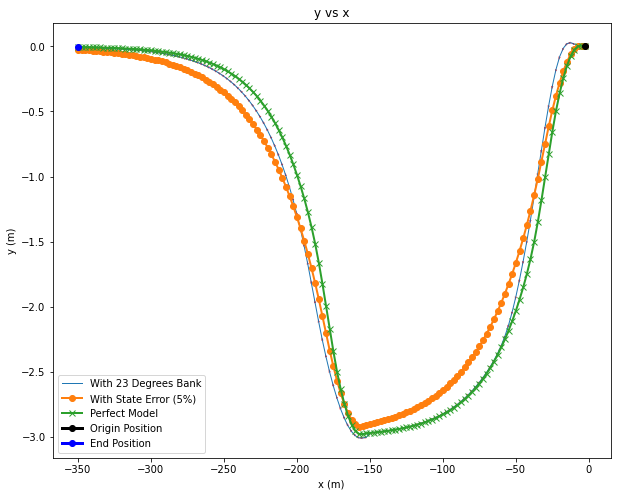

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(xd_array_bank, yd_array_bank, linewidth=1, label = "With 23 Degrees Bank")
plt.plot(xd_arrayr, yd_arrayr, linewidth=2, marker = 'o', label= "With State Error (5%)")
plt.plot(xd_arrayperf, yd_arrayperf, linewidth=2, marker = 'x', label= "Perfect Model")
plt.plot(xd_array_bank[0], yd_array_bank[0], c='black', marker='o', label = "Origin Position", linewidth=3) 
plt.plot(xd_array_bank[-1], yd_array_bank[-1], c='b', marker='o', label = "End Position", linewidth=3) 
plt.quiver(xd_array_bank[:-1], yd_array_bank[:-1], xd_array_bank[1:]-xd_array_bank[:-1], yd_array_bank[1:]-yd_array_bank[:-1], scale_units='x', angles='xy', scale=1, color = "r")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("y vs x")
plt.legend()
plt.show()

Text(0.5, 1.0, 'yd vs time')

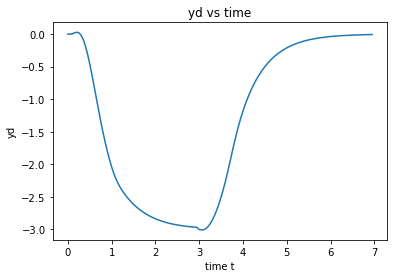

In [20]:
time_array = np.array(range(M))*Ts

plt.plot(time_array, yd_array_bank)
plt.xlabel("time t")
plt.ylabel("yd")
plt.title("yd vs time")

Text(0.5, 1.0, 'xd vs time')

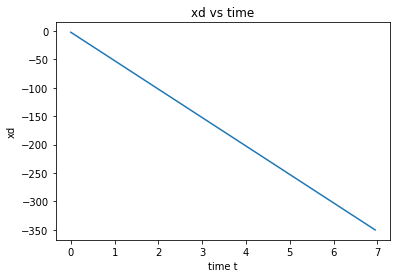

In [21]:
plt.plot(time_array, xd_array_bank)
plt.xlabel("time t")
plt.ylabel("xd")
plt.title("xd vs time")

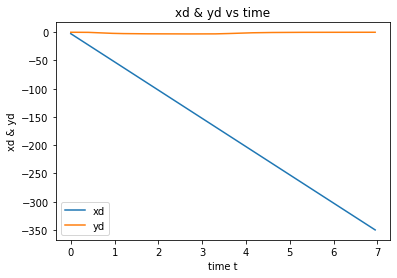

In [22]:
plt.plot(time_array, xd_array_bank, label = "xd")
plt.plot(time_array, yd_array_bank, label = "yd")
plt.xlabel("time t")
plt.ylabel("xd & yd")
plt.title("xd & yd vs time")
plt.legend()
plt.show()

In [23]:
print(slip_angle_array_bank.shape)
print(slip_angle_arrayr.shape)
print(slip_angle_arrayperf.shape)

(560,)
(560,)
(560,)


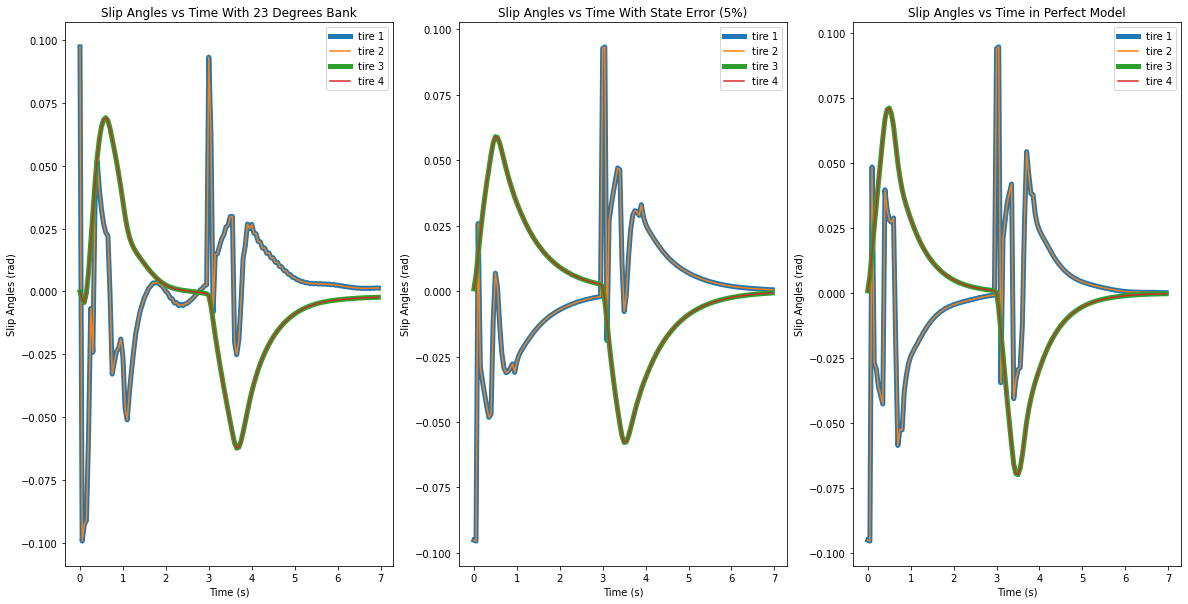

In [24]:
slip_angle_array_bank = slip_angle_array_bank.reshape((M,4))
slip_angle_arrayr = slip_angle_arrayr.reshape((M,4))
slip_angle_arrayperf = slip_angle_arrayperf.reshape((M,4))

fig = plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.plot(time_array, slip_angle_array_bank[:, 0], label = "tire 1", linewidth=5)
plt.plot(time_array, slip_angle_array_bank[:, 1], label = "tire 2")
plt.plot(time_array, slip_angle_array_bank[:, 2], label = "tire 3", linewidth=5)
plt.plot(time_array, slip_angle_array_bank[:, 3], label = "tire 4")
plt.xlabel("Time (s)")
plt.ylabel("Slip Angles (rad)")
plt.title("Slip Angles vs Time With 23 Degrees Bank")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(time_array, slip_angle_arrayr[:, 0], label = "tire 1", linewidth=5)
plt.plot(time_array, slip_angle_arrayr[:, 1], label = "tire 2")
plt.plot(time_array, slip_angle_arrayr[:, 2], label = "tire 3", linewidth=5)
plt.plot(time_array, slip_angle_arrayr[:, 3], label = "tire 4")
plt.xlabel("Time (s)")
plt.ylabel("Slip Angles (rad)")
plt.title("Slip Angles vs Time With State Error (5%)")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(time_array, slip_angle_arrayperf[:, 0], label = "tire 1", linewidth=5)
plt.plot(time_array, slip_angle_arrayperf[:, 1], label = "tire 2")
plt.plot(time_array, slip_angle_arrayperf[:, 2], label = "tire 3", linewidth=5)
plt.plot(time_array, slip_angle_arrayperf[:, 3], label = "tire 4")
plt.xlabel("Time (s)")
plt.ylabel("Slip Angles (rad)")
plt.title("Slip Angles vs Time in Perfect Model")
plt.legend()
plt.show()

In [ ]:
print(fz0_array_bank.shape)
print(fz0_arrayr.shape)
print(fz0_arrayperf.shape)

In [ ]:
print(fz0_array_bank)

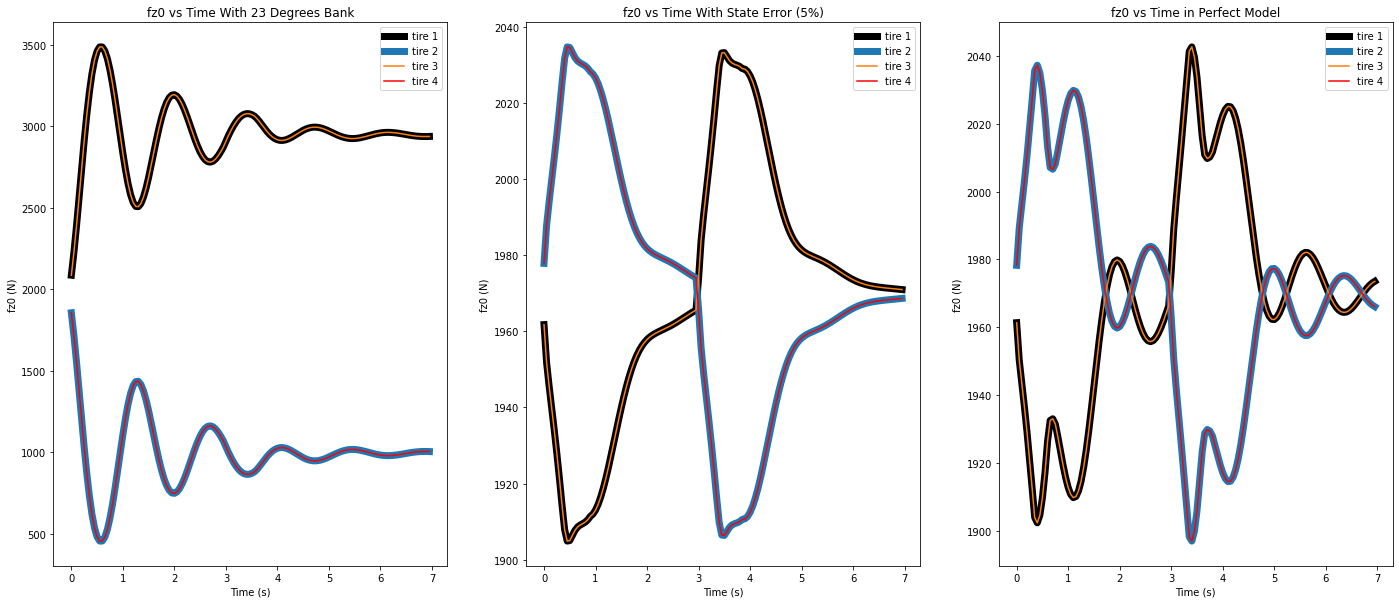

In [25]:
fz0_array_bank = fz0_array_bank.reshape((M,4))
fz0_arrayr = fz0_arrayr.reshape((M,4))
fz0_arrayperf = fz0_arrayperf.reshape((M,4))

fig = plt.figure(figsize=(24,10))
plt.subplot(1, 3, 1)
plt.plot(time_array, fz0_array_bank[:, 0], label = "tire 1", color = "black", linewidth=7)
plt.plot(time_array, fz0_array_bank[:, 1], label = "tire 2", linewidth=7)
plt.plot(time_array, fz0_array_bank[:, 2], label = "tire 3")
plt.plot(time_array, fz0_array_bank[:, 3], label = "tire 4", color = "red")
plt.xlabel("Time (s)")
plt.ylabel("fz0 (N)")
plt.title("fz0 vs Time With 23 Degrees Bank")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(time_array, fz0_arrayr[:, 0], label = "tire 1", color = "black", linewidth=7)
plt.plot(time_array, fz0_arrayr[:, 1], label = "tire 2", linewidth=7)
plt.plot(time_array, fz0_arrayr[:, 2], label = "tire 3")
plt.plot(time_array, fz0_arrayr[:, 3], label = "tire 4", color = "red")
plt.xlabel("Time (s)")
plt.ylabel("fz0 (N)")
plt.title("fz0 vs Time With State Error (5%)")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(time_array, fz0_arrayperf[:, 0], label = "tire 1", color = "black", linewidth=7)
plt.plot(time_array, fz0_arrayperf[:, 1], label = "tire 2", linewidth=7)
plt.plot(time_array, fz0_arrayperf[:, 2], label = "tire 3")
plt.plot(time_array, fz0_arrayperf[:, 3], label = "tire 4", color = "red")
plt.xlabel("Time (s)")
plt.ylabel("fz0 (N)")
plt.title("fz0 vs Time in Perfect Model")
plt.legend()
plt.show()